__Install conda and load modules__

After installing [miniconda](https://conda.io/miniconda.html), install the following packages:

matplotlib numpy scipy astropy pandas yt xarray healpy

by typing the following into the command prompt

> $conda install matplotlib numpy scipy astropy pandas yt xarray [healpy]

anything else..?

* __I've been using python 2.7.x but let's try to stick to the python 3.x standard.__


* __tigradpy is a rewrite of pyathena. Currently, it is a submodule only to the radiation (and ionrad-dev) branch...much work has to be done__

In [2]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import yt

yt.funcs.mylog.setLevel(50) # suppress log messages except for critical ones
# add tigradpy to python path..
sys.path.insert(0, '../../')
sys.path.insert(0, '../../pyathena') # add Chang-Goo's pyathena to python path
import tigradpy as tp 
import pyathena as pa
print(tp.__all__)

['add_fields', 'plt_multipanel', 'read_athinput', 'read_hst', 'read_zprof', 'read_zprof_all']


__Read simulation input parameters using read_athinput__

In [3]:
datadir = '/tigress/jk11/tigrad_pp/rad_8pc_pp_dmax1024/'
#datadir = '/scratch/gpfs/jk11/tigrad_pp/rad_8pc_pp_dmax1024/'
fathinput = os.path.join(datadir, 'out.txt')
par = tp.read_athinput(fathinput) # par is a namedtuple object

print(par._fields)

print(type(par.problem)) # each item of par is a dictionary
# problem block
print('\n','<problem>')
for k, v in par.problem.iteritems():
    print('*',k,':',v)
print('\n','<radps>')
# radps block
for k, v in par.radps.iteritems():
    print('*',k,':',v)
print('\n','<configure>')
# seems like some entries in configure block are not read properly
for k, v in par.configure.iteritems():
    print('*',k,':',v)

('log', 'output2', 'output3', 'output1', 'feedback', 'output4', 'radps', 'job', 'time', 'domain1', 'problem', 'configure')
<type 'dict'>

 <problem>
* num_end : 400
* num_start : 200
* active_age : 15.0
* basedir : /scratch/gpfs/jk11/tigrad_pp/rad_8pc
* grow_age : 4.0
* rho_crit : 1.0
* qshear : 1.0
* num_stride : 10
* Omega : 28.e-3
* problem_id : rad_8pc
* gamma : 1.66666666667

 <radps>
* zm : -205.0
* nexitPP_max_def : 100
* hnu[0] : 18.0
* tau_max : 7.0
* min_pix_level : 4
* sigma_ph[0] : 2.7e-18
* dt_sub_min : 0.0
* dt_sub_no : 10.0
* zp : 205.0
* nfreq : 2
* dt_rayt_over_dt_2p : 1.0
* kappa_dust[1] : 500.0
* dmaxPP : 1024.0
* maxiter : 500
* ray_number : 4
* sigma_ph[1] : 0.0
* nfreq_ion : 1
* apply_rad_force : 0
* N_mu : 64
* kappa_dust[0] : 500.0
* hnu[1] : 10.0
* rotate_interval : 1

 <configure>
* config server : perseus
* resistivity : OFF
* special_relativity : no
* config date : Wed
* coord : Cartesian
* star particles : strict
* git : ID
* nscalars : 4
* eq_state : adiab

__Read vtk file using yt and add derived fields__

In [4]:
## this is very inconvenient..need to write a conveience unit object
import yt.units as yu
from yt import physical_constants as phyc
units_override = dict(length_unit=(1., 'pc'),
                      time_unit=((yu.pc/(yu.km/yu.s)).in_units('Myr'), 'Myr'),
                      mass_unit=((1.4272*phyc.mass_hydrogen_cgs*
                                 (yu.pc/yu.cm)**3).in_units('Msun'), 'Msun'))

num = 15
filename = os.path.join(datadir, 'rad_8pc_pp.{0:04d}.vtk'.format(num))

##Somehow yt spits out a strange warning message when dataset is loaded..
# ds = yt.load(filename, units_override=units_override)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds = yt.load(filename, units_override=units_override)


tp.add_fields(ds, IXN=3)

__all vtk output variables are in code unit.__

In [5]:
ds.field_list

[('athena', 'density'),
 ('athena', 'heat_ratio'),
 ('athena', 'pressure'),
 ('athena', 'rad_energy_density0'),
 ('athena', 'rad_energy_density1'),
 ('athena', 'rad_flux0_x'),
 ('athena', 'rad_flux0_y'),
 ('athena', 'rad_flux0_z'),
 ('athena', 'rad_flux1_x'),
 ('athena', 'rad_flux1_y'),
 ('athena', 'rad_flux1_z'),
 ('athena', 'specific_scalar[0]'),
 ('athena', 'specific_scalar[1]'),
 ('athena', 'specific_scalar[2]'),
 ('athena', 'specific_scalar[3]'),
 ('athena', 'velocity_x'),
 ('athena', 'velocity_y'),
 ('athena', 'velocity_z')]

__Let's see how derived fields can be added to yt dataset.__

In [6]:
# %load ../add_fields.py
import numpy as np
import yt.units as yu
from yt import physical_constants as phyc

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

def add_fields(ds, IXN=3,
               kappa_dust=500.0*yu.cm**2/yu.g, 
               sigma_ph=3.0e-18*yu.cm**2,
               muH=1.4272,
               y=0.0,
               units='LT'):
    """
    Function to add derived fields to yt dataset.
    
    Parameters
    ----------
       ds: yt dataset

       IXN: integer
           index for neutral hydrogen in specific_scalar array
           in athena vtk dump
       kappa_dust: float
           (constant) dust opacity in FUV and EUV
       sigma_ph: float
           (constant) photoionization cross section
       y: float
           Contribution to electron density from all heavy elements
           ne = (1 - xn + y)*nH
    """
    
    # Set code units
    if units == 'LT':
        lunit = yu.pc
        tunit = yu.Myr
        munit = (muH*phyc.mass_hydrogen_cgs*(yu.pc/yu.cm)**3).in_units('Msun')
    elif units == 'LV':
        lunit = yu.pc
        tunit = yu.pc/(yu.km/yu.s)
        munit = (muH*phyc.mass_hydrogen_cgs*(yu.pc/yu.cm)**3).in_units('Msun')
    elif units == 'cgs':
        lunit = yu.cm
        tunit = yu.s
        munit = yu.g
        
    vunit = lunit/tunit
    Eunit = munit/(lunit*tunit**2)       # energy density
    Funit = (Eunit*lunit/tunit).in_cgs() # flux

    field_xn = "specific_scalar[{0:d}]".format(IXN)
    
    # Number density of H, HI and H neutral fraction
    def _nH(field, data):
        return data["density"]/(muH*phyc.mass_hydrogen_cgs)
    ds.add_field(("athena","nH"), sampling_type="cell", function=_nH,
                 units='cm**(-3)', display_name=r'$n_{\rm H}$')
    def _xn(field, data):
        return data[("athena",field_xn)]
    ds.add_field(("athena","xn"), sampling_type="cell",
                 function=_xn,units="dimensionless",
                 take_log=False, display_name=r'$x_{\rm n}$')
    def _nHI(field, data):
        return data[("athena","xn")]*data[("athena","nH")]
    ds.add_field(("athena","nHI"), sampling_type="cell", 
                 function=_nHI,units="cm**-3", take_log=True,
                 display_name=r'$n_{\rm HI}$')

    # electron number density: assume ne = (1 - xn + y)*nH
    @static_vars(y=y)
    def _nelec(field, data):
        return (1.0 - data[("athena",field_xn)] + y)*\
                data[("athena","nH")]
    ds.add_field(("athena","nelec"), sampling_type="cell",
                 function=_nelec, units="cm**-3", take_log=True,
                 display_name=r'$n_{e}$')
    def _nesq(field, data):
        return data["nelec"]**2
    ds.add_field("nesq", sampling_type="cell",
                 function=_nesq, units="cm**-6", take_log=True,
                 display_name=r'$n_{e}^2$')

    # Temperature
    def _Temperature(field, data):
        return data["pressure"]/((1.1*data[("athena","nH")] + data["nelec"])*phyc.kb)
    ds.add_field("Temperature", sampling_type="cell",
                 function=_Temperature, units="K", take_log=True,
                 display_name=r'$T$')
    
    def _density_ion(field, data):
        return (1.0 - data[("athena",field_xn)])*data[("athena","density")]
    ds.add_field(("athena","density_ion"), sampling_type="cell",
                 function=_density_ion, units="g*cm**-3", take_log=True, 
                 display_name=r'$\rho_{\rm i}$')
    def _density_neu(field, data):
        return data[("athena", field_xn)]*data[("athena", "density")]
    ds.add_field(("athena","density_neu"), sampling_type="cell",
                 function=_density_neu, units="g*cm**-3", take_log=True,
                 display_name=r'$\rho_{\rm n}$')

    # Mean radiation intensity relative to the solar nbhd value
    # (for FUV) 2.1e-4 [cgs units]
    def _Erad0(field, data):
        return data[("athena","rad_energy_density0")]*Eunit
    ds.add_field(("gas","Erad0"), sampling_type="cell", function=_Erad0,
                 units="erg/cm**3", take_log=True,
                 display_name=r'$\mathcal{E}_{\rm EUV}$')
    def _Jrad0(field, data):
        return data["Erad0"]/(4.0*np.pi*yu.sr)*phyc.clight
    ds.add_field("Jrad0", sampling_type="cell", function=_Jrad0,
                 units="erg/cm**2/sr/s", take_log=True,
                 display_name=r'$J_{\rm EUV}$')
    def _G0prime0(field, data):
        return data["Jrad0"]/(2.1e-4*yu.erg/yu.cm**2/yu.s/yu.sr)
    ds.add_field("G0prime0", sampling_type="cell",
                 function=_G0prime0, units="dimensionless", take_log=True,
                 display_name=r'$G_{0,{\rm EUV}}^{\prime}$')
    
    def _Erad1(field, data):
        return data[("athena","rad_energy_density1")]*Eunit
    ds.add_field(("gas","Erad1"), sampling_type="cell",
                 function=_Erad1, units="erg/cm**3", take_log=True,
                 display_name=r'$\mathcal{E}_{\rm FUV}$')
    def _Jrad1(field, data):
        return data["Erad1"]/(4.0*np.pi*yu.sr)*phyc.clight
    ds.add_field("Jrad1", sampling_type="cell",
                 function=_Jrad1, units="erg/cm**2/sr/s", take_log=True,
                 display_name=r'$J_{\rm FUV}$')
    def _G0prime1(field, data):
        return data["Jrad1"]/(2.1e-4*yu.erg/yu.cm**2/yu.s/yu.sr)
    ds.add_field("G0prime1", sampling_type="cell", 
                 function=_G0prime1, units="dimensionless", take_log=True,
                 display_name=r'$G_{0,{\rm FUV}}^{\prime}$')

    # absorption coefficient per unit length
    @static_vars(kappa_dust=kappa_dust)
    def _chi_nion(field, data):
        return _chi_nion.kappa_dust*data["density"]
    ds.add_field("chi_nion", sampling_type="cell", 
                 function=_chi_nion, units="1/cm", take_log=True,
                 display_name=r'$\chi_{\rm FUV}$')

    @static_vars(kappa_dust=kappa_dust)
    @static_vars(sigma_ph=sigma_ph)
    def _chi_ion(field, data):
        return _chi_ion.kappa_dust*data["density"] + \
               _chi_ion.sigma_ph*data[("athena","nHI")]
    ds.add_field("chi_ion", sampling_type="cell",
                 function=_chi_ion, units="1/cm", take_log=True,
                 display_name=r'$\chi_{\rm EUV}$')

    # for y slice or projection, make x-z as XY axes in the image
    ds.coordinates.x_axis[1] = 0
    ds.coordinates.x_axis['y'] = 0
    ds.coordinates.y_axis[1] = 2
    ds.coordinates.y_axis['y'] = 2



__Example x-z and x-y slices and projections of $n_{\rm H}$, $x_n$, radiation densities__

G0prime1: FUV Mean intensity normalized by solar neighborhood value
\begin{equation}
    {\rm G0prime1} = J_{\rm FUV}/(2.1 \times 10^{-4}\,{\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1}\,{\rm sr}^{-1})
\end{equation}

Similarly, define EUV mean intensity as
\begin{equation}
    {\rm G0prime0} = J_{\rm EUV}/(2.1 \times 10^{-4}\,{\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1}\,{\rm sr}^{-1})
\end{equation}

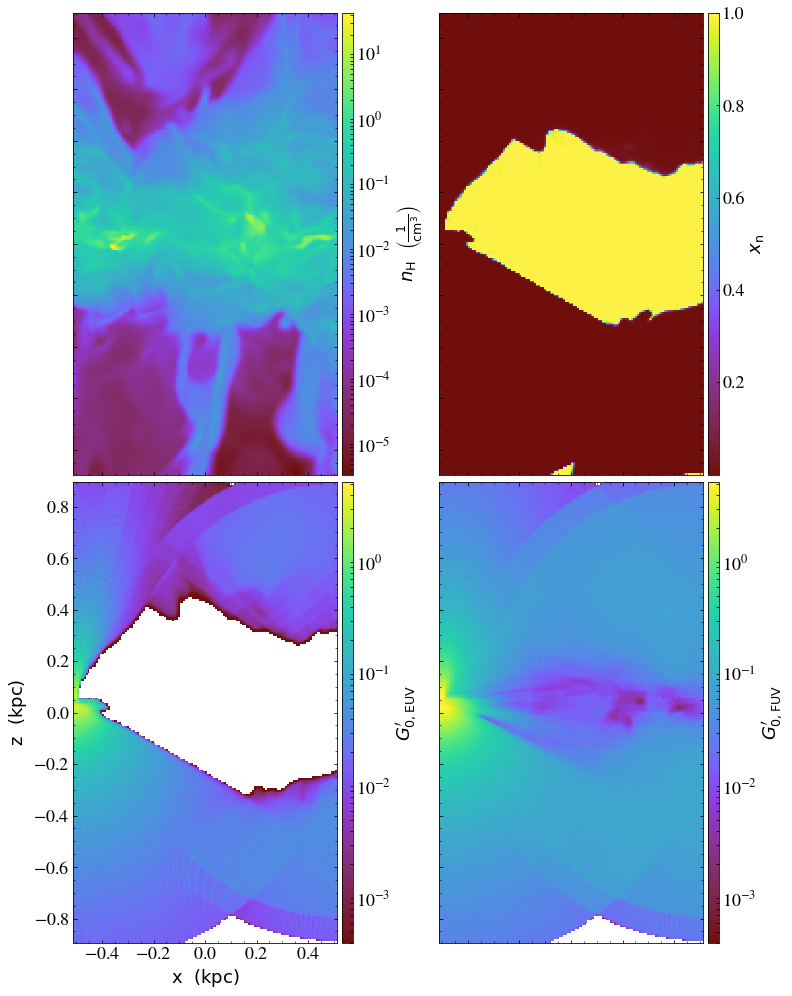

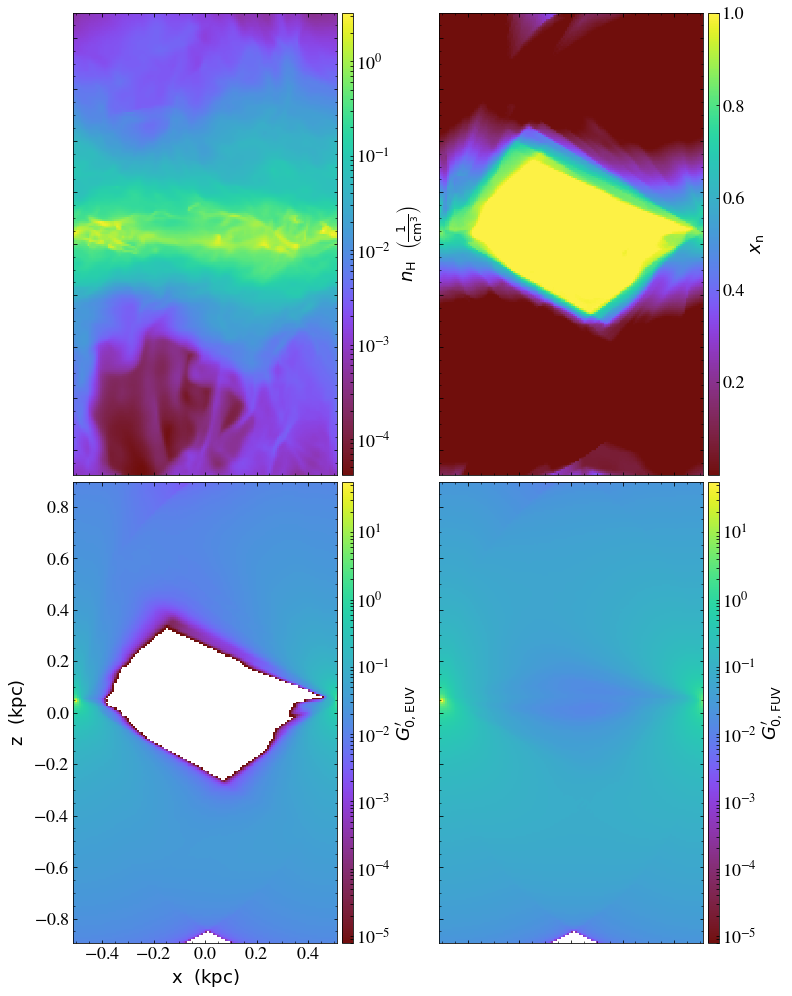

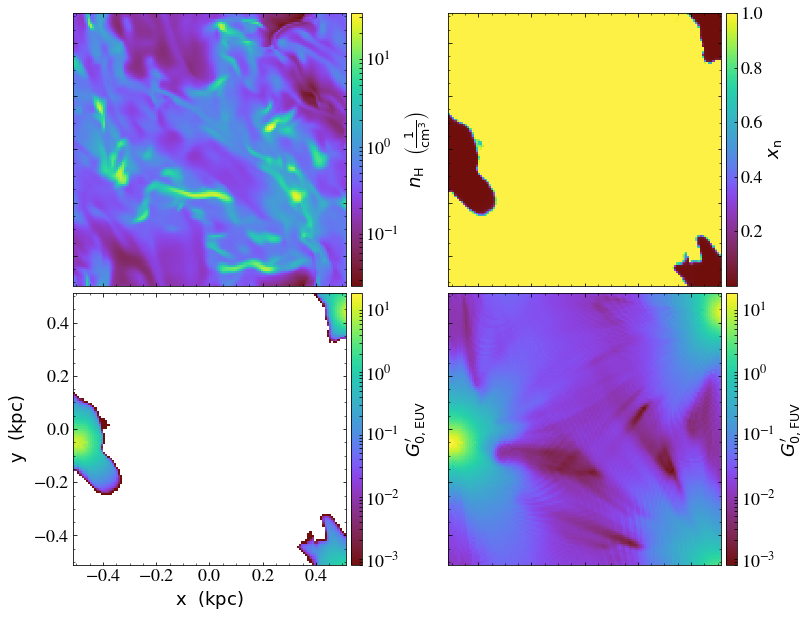

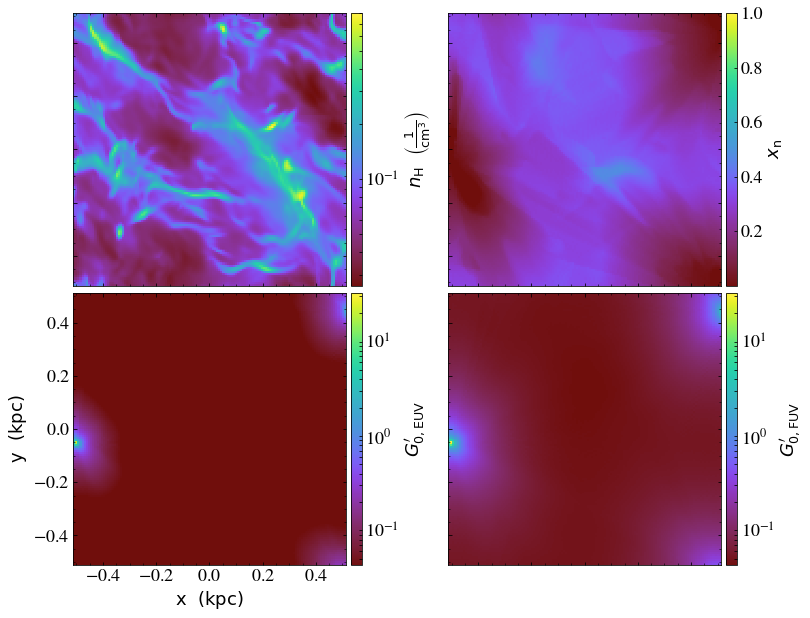

In [17]:
fields = ['nH', 'xn', 'G0prime0', 'G0prime1']

sy = tp.plt_multipanel(ds, 'slice', 'y', fields=fields)
py = tp.plt_multipanel(ds, 'projection', 'y', fields=fields)
sz = tp.plt_multipanel(ds, 'slice', 'z', fields=fields)
pz = tp.plt_multipanel(ds, 'projection', 'z', fields=fields)

__Plot multiple snapshots and save__

In [27]:
fields = ['nH', 'xn', 'G0prime0', 'G0prime1']
kind = (['slice','y'],['slice','z'],
        ['projection','y'],['projection','z'])

num = range(1, 21, 1)
datadir = '/tigress/jk11/tigrad_pp/rad_8pc_pp_dmax1024/'
savdir = os.path.join(os.path.expanduser('~'),
                      'snapshots-rad_8pc_pp_dmax1024/')

for num_ in num:
    print(num_, end=' ')
    filename = os.path.join(datadir, 'rad_8pc_pp.{0:04d}.vtk'.format(num_))
    ds_ = yt.load(filename, units_override=units_override)
    tp.add_fields(ds_, IXN=3)
    for kind_, axis_ in kind:
        fname = '{0:s}_{1:s}_{2:04d}.png'.format(kind_, axis_, num_)
        p_ = tp.plt_multipanel(ds_, kind_, axis_, fields=fields)
        fig = p_.plots[fields[0]].figure # reference to the mpl figure
        fig.savefig(os.path.join(savdir, fname))
        plt.close(fig)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

__midplane slices from raw arrays__

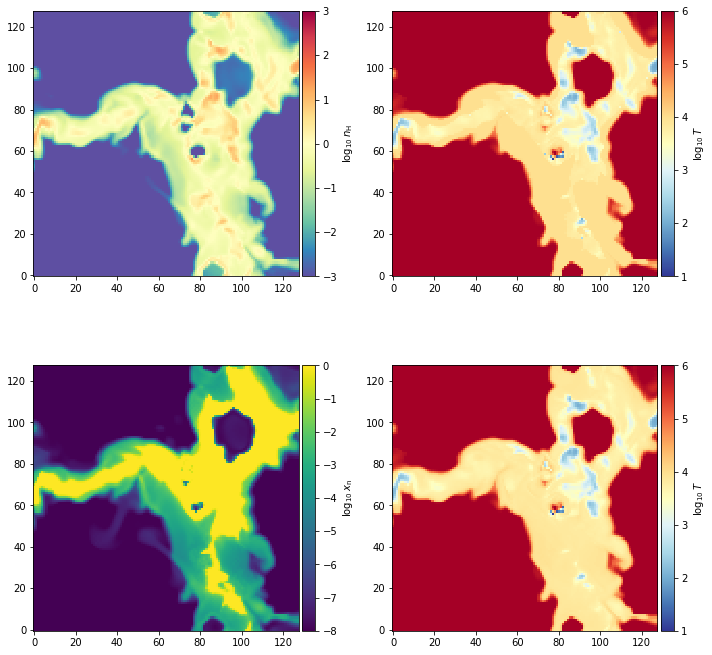

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

Nx1 = par.domain1['Nx1']
Nx2 = par.domain1['Nx2']
Nx3 = par.domain1['Nx3']
ix = Nx1
iy = Nx2
iz = Nx3/2

num = 5
# read joined vtk..
datadir = '/scratch/gpfs/jk11/tigrad_pp/rad_8pc_pp_dmax1024/'
filename = os.path.join(datadir, 'rad_8pc_pp.{0:04d}.vtk'.format(num))
ds = yt.load(filename, units_override=units_override)
tp.add_fields(ds, IXN=3)

da = ds.all_data()
den = da['nH'].reshape(Nx1,Nx2,Nx3)[:,:,iz].v
T = da['Temperature'].reshape(Nx1,Nx2,Nx3)[:,:,iz].v
#Tma = np.ma.masked_where(T > 1e4, T)

plt.sca(axes[0])
im0 = plt.imshow(np.log10(den).T, origin='lower', vmin=-3, vmax=3,
                 cmap='Spectral_r')
divider = make_axes_locatable(plt.gca())
cax0 = divider.append_axes('right', size='5%', pad=0.05)
cb0 = plt.colorbar(im0, cax=cax0)
cb0.set_label(r'$\log_{10}\,n_{\rm H}$')

plt.sca(axes[1])
im1 = plt.imshow(np.log10(T).T, origin='lower', vmin=1.0, vmax=6,
                 cmap='RdYlBu_r')
divider = make_axes_locatable(plt.gca())
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$\log_{10}\,T$')

plt.sca(axes[2])
xn = da['xn'].reshape(Nx1,Nx2,Nx3)[:,:,iz].v
im2 = plt.imshow(np.log10(xn).T, origin='lower', vmin=-8.0, vmax=0.0,
                 cmap='viridis')
divider = make_axes_locatable(plt.gca())
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)
cb2.set_label(r'$\log_{10}\,x_{\rm n}$')


num = 5
num_orig = int(par.problem['num_start'] + (num-1)*(par.problem['num_stride']))

datadir_orig = '/tigress//jk11/tigrad_pp/rad_8pc'
#datadir = '/home/jk11/athena-tigress/bin'
filename = os.path.join(datadir_orig, 'rad_8pc.{0:04d}.vtk'.format(num_orig))

##############################################################
## Read original data (before postprocessing) using pyathena
## (bottom right panel)
##############################################################

import pyathena as pa
import astropy.constants as ac
import astropy.units as au

ds_orig = pa.AthenaDataSet(filename)
den3d = ds_orig.read_all_data('density')
P = ds_orig.read_all_data('pressure')
unit = pa.set_units(muH=1.4272)
to_pok=(unit['pressure']/ac.k_B).cgs.value
pok = P*to_pok
T1_new = pok/den/1.4272
T1 = ds_orig.read_all_data('T1')
temp = pa.coolftn.get_temp(T1)
den_orig = den3d[112,:,:]
T_orig = temp[112,:,:]

plt.sca(axes[3])
im1 = plt.imshow(np.log10(T_orig), origin='lower', vmin=1.0, vmax=6,
                 cmap='RdYlBu_r')
divider = make_axes_locatable(plt.gca())
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$\log_{10}\,T$')
plt.tight_layout()

##### Compare temperature before and after post-processing

Text(0,0.5,'T (after postproc) [K]')

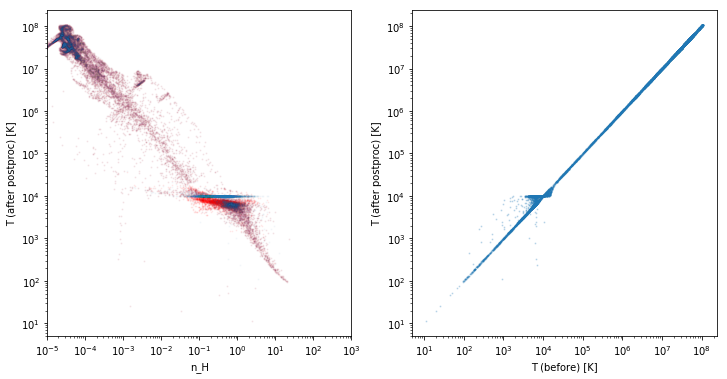

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
plt.scatter(den_orig.flatten(), T_orig.flatten(), alpha=0.05, s=1, c='r')
plt.scatter(den.flatten(), T.flatten(), alpha=0.03, s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n_H')
plt.ylabel('T (after postproc) [K]')
plt.xlim(1e-5, 1e3)

plt.sca(axes[1])
plt.scatter(T_orig.flatten(), T.T.flatten(), alpha=0.2, s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T (before) [K]')
plt.ylabel('T (after postproc) [K]')
#plt.xlim(1e-5,1e2)

__Read zprof__

Index([u'z', u'A', u'd', u'v1', u'v2', u'v3', u'M1', u'M2', u'M3', u'Ek1',
       u'Ek2', u'Ek3', u'P', u'T', u'dM2', u'dEk2', u'Phie', u'gext', u'dWext',
       u'Phisg', u'gsg', u'dWsg', u'Ber', u'cool', u'heat', u's1', u's2',
       u's3', u's4', u'pA', u'pd', u'pvz', u'pFzd', u'pFzM1', u'pFzM2',
       u'pFzM3', u'pFzE1', u'pFzE2', u'pFzE3', u'pFzP', u'pFzEge', u'pFzEgsg',
       u'pFzEtidal', u'pFzs1', u'pFzs2', u'pFzs3', u'pFzs4', u'mA', u'md',
       u'mvz', u'mFzd', u'mFzM1', u'mFzM2', u'mFzM3', u'mFzE1', u'mFzE2',
       u'mFzE3', u'mFzP', u'mFzEge', u'mFzEgsg', u'mFzEtidal', u'mFzs1',
       u'mFzs2', u'mFzs3', u'mFzs4', u'RxyL', u'RxyR', u'Erad0', u'Erad1'],
      dtype='object')


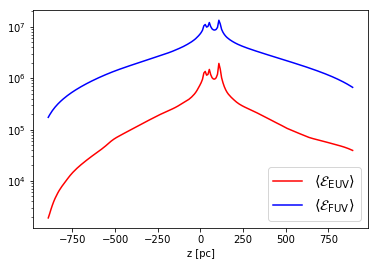

In [16]:
num = 5
filename = os.path.join(datadir, 'id0', 
                        'rad_8pc_pp.{0:04d}.whole.zprof'.format(num))
zp = tp.read_zprof(filename)
print(zp.columns)
plt.plot(zp.z, zp.Erad0, 'r-', label=r'$\langle\mathcal{E}_{\rm EUV}\rangle$')
plt.plot(zp.z, zp.Erad1, 'b-', label=r'$\langle\mathcal{E}_{\rm FUV}\rangle$')
plt.yscale('log')
plt.xlabel('z [pc]')
plt.legend(fontsize='x-large')

__Read all zprof__

In [38]:
zpa = tp.read_zprof_all(os.path.join(datadir, 'id0'), 'rad_8pc_pp')
print(type(zpa))
zpa.coords,zpa.fields

<class 'xarray.core.dataarray.DataArray'>


(Coordinates:
   * z        (z) float64 -892.0 -884.0 -876.0 -868.0 -860.0 -852.0 -844.0 ...
   * fields   (fields) |S9 'z' 'A' 'd' 'v1' 'v2' 'v3' 'M1' 'M2' 'M3' 'Ek1' ...
   * time     (time) float64 1.35e+03 1.22e+03 1.26e+03 1.29e+03 0.0 1.31e+03 ...,
 <xarray.DataArray 'fields' (fields: 69)>
 array(['z', 'A', 'd', 'v1', 'v2', 'v3', 'M1', 'M2', 'M3', 'Ek1', 'Ek2', 'Ek3',
        'P', 'T', 'dM2', 'dEk2', 'Phie', 'gext', 'dWext', 'Phisg', 'gsg',
        'dWsg', 'Ber', 'cool', 'heat', 's1', 's2', 's3', 's4', 'pA', 'pd',
        'pvz', 'pFzd', 'pFzM1', 'pFzM2', 'pFzM3', 'pFzE1', 'pFzE2', 'pFzE3',
        'pFzP', 'pFzEge', 'pFzEgsg', 'pFzEtidal', 'pFzs1', 'pFzs2', 'pFzs3',
        'pFzs4', 'mA', 'md', 'mvz', 'mFzd', 'mFzM1', 'mFzM2', 'mFzM3', 'mFzE1',
        'mFzE2', 'mFzE3', 'mFzP', 'mFzEge', 'mFzEgsg', 'mFzEtidal', 'mFzs1',
        'mFzs2', 'mFzs3', 'mFzs4', 'RxyL', 'RxyR', 'Erad0', 'Erad1'],
       dtype='|S9')
 Coordinates:
   * fields   (fields) |S9 'z' 'A' 'd' 'v1' 'v2' 'v3' 'M1' 

In [41]:
print(zpa.loc['Erad0'].shape)
Erad0 = zpa.loc['Erad0']

(224, 22)


<xarray.DataArray 'z' ()>
array(-892.) <xarray.DataArray 'z' ()>
array(892.)


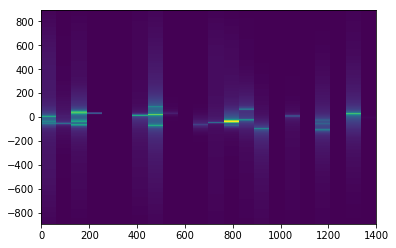

In [55]:
plt.figure()
print(zpa.z.min(), zpa.z.max())
extent=(zpa.time.min(),zpa.time.max(), zpa.z.min(), zpa.z.max())
plt.imshow(Erad0, aspect=0.5, extent=extent)

* __3d vtk can be joined using shell script__


* __For full details, type athena-tigress/vtk/join.sh -h__


* __See also Python parallel wrapper script__

In [14]:
import subprocess
subprocess.call(['../../../vtk/join.sh','-r','1:7','-i',datadir])

0